# COVID-19 Vaccine Forecasting

## Part 2 - Data Cleaning

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.utils import set_random_seed

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import os
import random

In [2]:
# create function that sets OS `PYTHONHASHSEED` environment variable,
# Python, NumPy, and TensorFlow seeds at a fixed value
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    random.seed(42)
    np.random.seed(42)
    set_random_seed(42)

reset_seeds()

In [3]:
# read in data into a pandas dataframe
# for reproducibility, a CSV was saved of the data that was available at the time this project was completed
df = pd.read_csv('../data/us_state_vaccinations_09_04_21.csv')

In [4]:
# first look at the data
df.head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,total_boosters,total_boosters_per_hundred
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,NaN,NaN
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212,NaN,NaN
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,NaN,NaN
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7498.0,1529.0,NaN,NaN,NaN


In [5]:
# set the index
df.set_index(df['date'], inplace=True)

# sort the index
df.sort_index(axis=1, inplace=True)

# check dataframe 
df.head()

,daily_vaccinations,daily_vaccinations_per_million,daily_vaccinations_raw,date,distributed_per_hundred,location,people_fully_vaccinated,people_fully_vaccinated_per_hundred,people_vaccinated,people_vaccinated_per_hundred,share_doses_used,total_boosters,total_boosters_per_hundred,total_distributed,total_vaccinations,total_vaccinations_per_hundred
date,,,,,,,,,,,,,,,,
2021-01-12,NaN,NaN,NaN,2021-01-12,7.69,Alabama,7270.0,0.15,70861.0,1.45,0.207,NaN,NaN,377025.0,78134.0,1.59
2021-01-13,5906.0,1205.0,5906.0,2021-01-13,7.73,Alabama,9245.0,0.19,74792.0,1.53,0.222,NaN,NaN,378975.0,84040.0,1.71
2021-01-14,7083.0,1445.0,8260.0,2021-01-14,8.88,Alabama,NaN,NaN,80480.0,1.64,0.212,NaN,NaN,435350.0,92300.0,1.88
2021-01-15,7478.0,1525.0,8267.0,2021-01-15,9.07,Alabama,13488.0,0.28,86956.0,1.77,0.226,NaN,NaN,444650.0,100567.0,2.05
2021-01-16,7498.0,1529.0,NaN,2021-01-16,NaN,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# set the index to datetime
df.index = pd.to_datetime(df.index)

In [7]:
# confirm that the index is in datetime format
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15363 entries, 2021-01-12 to 2021-09-04
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   daily_vaccinations                   15298 non-null  float64
 1   daily_vaccinations_per_million       14323 non-null  float64
 2   daily_vaccinations_raw               14275 non-null  float64
 3   date                                 15363 non-null  object 
 4   distributed_per_hundred              13745 non-null  float64
 5   location                             15363 non-null  object 
 6   people_fully_vaccinated              14361 non-null  float64
 7   people_fully_vaccinated_per_hundred  13659 non-null  float64
 8   people_vaccinated                    14441 non-null  float64
 9   people_vaccinated_per_hundred        13734 non-null  float64
 10  share_doses_used                     14452 non-null  float64
 11  total_boost

In [8]:
# create a mask to set the dataframe equal to the state of massachusetts
mask = df['location'] == 'Massachusetts'
df = df[mask]

In [9]:
# check for null values
df.isnull().sum()

daily_vaccinations                       1
daily_vaccinations_per_million           1
daily_vaccinations_raw                  11
date                                     0
distributed_per_hundred                  6
location                                 0
people_fully_vaccinated                  7
people_fully_vaccinated_per_hundred      7
people_vaccinated                        6
people_vaccinated_per_hundred            6
share_doses_used                         6
total_boosters                         236
total_boosters_per_hundred             236
total_distributed                        6
total_vaccinations                       6
total_vaccinations_per_hundred           6
dtype: int64

In [10]:
df.head()

,daily_vaccinations,daily_vaccinations_per_million,daily_vaccinations_raw,date,distributed_per_hundred,location,people_fully_vaccinated,people_fully_vaccinated_per_hundred,people_vaccinated,people_vaccinated_per_hundred,share_doses_used,total_boosters,total_boosters_per_hundred,total_distributed,total_vaccinations,total_vaccinations_per_hundred
date,,,,,,,,,,,,,,,,
2021-01-12,NaN,NaN,NaN,2021-01-12,6.91,Massachusetts,19073.0,0.28,184984.0,2.68,0.429,NaN,NaN,476025.0,204082.0,2.96
2021-01-13,13361.0,1938.0,13361.0,2021-01-13,9.53,Massachusetts,24789.0,0.36,192619.0,2.79,0.331,NaN,NaN,656850.0,217443.0,3.15
2021-01-14,14697.0,2132.0,16033.0,2021-01-14,9.71,Massachusetts,NaN,NaN,204481.0,2.97,0.349,NaN,NaN,669225.0,233476.0,3.39
2021-01-15,17698.0,2568.0,23699.0,2021-01-15,9.71,Massachusetts,34885.0,0.51,222109.0,3.22,0.384,NaN,NaN,669325.0,257175.0,3.73
2021-01-16,17130.0,2485.0,NaN,2021-01-16,NaN,Massachusetts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# check indexes of missing values
missingv = df["total_vaccinations"].isnull().to_numpy().nonzero()
print(missingv)

(array([  4,   5,   6,  34, 139, 174]),)


In [12]:
# interpolate missing values
# since missing values are all float objects, I can interpolate on the whole dataframe
df.interpolate(inplace=True)

In [13]:
# check for remaining missing values
df.isnull().sum()

daily_vaccinations                       1
daily_vaccinations_per_million           1
daily_vaccinations_raw                   1
date                                     0
distributed_per_hundred                  0
location                                 0
people_fully_vaccinated                  0
people_fully_vaccinated_per_hundred      0
people_vaccinated                        0
people_vaccinated_per_hundred            0
share_doses_used                         0
total_boosters                         236
total_boosters_per_hundred             236
total_distributed                        0
total_vaccinations                       0
total_vaccinations_per_hundred           0
dtype: int64

In [14]:
# drop booster-related columns
df.drop(columns = ['total_boosters', 'total_boosters_per_hundred'], axis = 1, inplace=True)

# drop first row
df.dropna(inplace=True)

# check shape
df.shape

(235, 14)

In [15]:
# drop the location column
df.drop('location', axis=1, inplace=True)

# check dataframe
df.head()

,daily_vaccinations,daily_vaccinations_per_million,daily_vaccinations_raw,date,distributed_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,people_vaccinated,people_vaccinated_per_hundred,share_doses_used,total_distributed,total_vaccinations,total_vaccinations_per_hundred
date,,,,,,,,,,,,,
2021-01-13,13361.0,1938.0,13361.0,2021-01-13,9.53,24789.0,0.3600,192619.00,2.7900,0.331,656850.0,217443.0,3.150
2021-01-14,14697.0,2132.0,16033.0,2021-01-14,9.71,29837.0,0.4350,204481.00,2.9700,0.349,669225.0,233476.0,3.390
2021-01-15,17698.0,2568.0,23699.0,2021-01-15,9.71,34885.0,0.5100,222109.00,3.2200,0.384,669325.0,257175.0,3.730
2021-01-16,17130.0,2485.0,21281.8,2021-01-16,9.71,36427.0,0.5325,235984.75,3.4225,0.407,669325.0,272600.5,3.955
2021-01-17,16789.0,2436.0,18864.6,2021-01-17,9.71,37969.0,0.5550,249860.50,3.6250,0.430,669325.0,288026.0,4.180


In [16]:
# check for missing dates in the timeseries
pd.date_range(start = "2021-01-13", end = "2021-09-04").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

There are no remaining missing datapoints in the data!

In [17]:
# # save clean csv
# df.to_csv("../data/massachusetts_vaccinations_09_04_21_clean.csv", index=False)

## Exploratory Data Analysis

### Plotting features of interest to evaluate trend

In [18]:
# Look at each column
df.columns

Index(['daily_vaccinations', 'daily_vaccinations_per_million',
       'daily_vaccinations_raw', 'date', 'distributed_per_hundred',
       'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
       'people_vaccinated', 'people_vaccinated_per_hundred',
       'share_doses_used', 'total_distributed', 'total_vaccinations',
       'total_vaccinations_per_hundred'],
      dtype='object')

In [19]:
# create list of features of interest
features = ["total_distributed", "total_vaccinations", "people_vaccinated", "people_fully_vaccinated", "daily_vaccinations"]

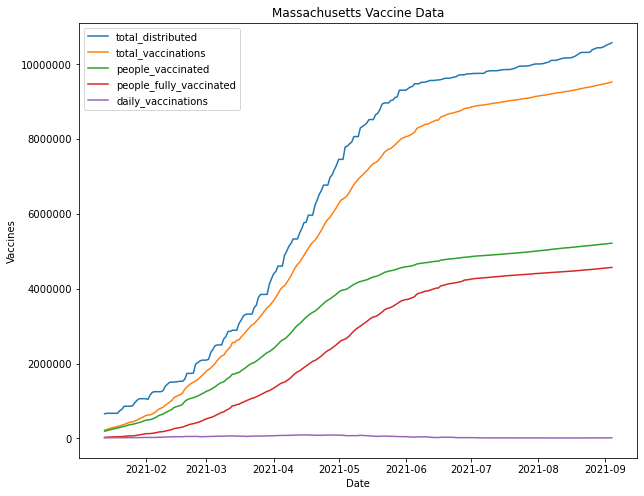

In [20]:
# plot features
fig, ax = plt.subplots(figsize=(10,8))

ax.yaxis.get_major_formatter().set_scientific(False)

plt.title("Massachusetts Vaccine Data")
plt.xlabel('Date')
plt.ylabel('Vaccines')
for feature in features:
    plt.plot(df[feature], label = feature)
    plt.legend();

"people_fully_vaccinated", "people_vaccinated", "total_vaccinations", and "total_distributed" all have positive trends.

In [21]:
# check correlation of features of interest
df[features].corr()

,total_distributed,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
total_distributed,1.000000,0.998560,0.997387,0.992540,-0.303775
total_vaccinations,0.998560,1.000000,0.996374,0.996247,-0.331853
people_vaccinated,0.997387,0.996374,1.000000,0.985337,-0.251742
people_fully_vaccinated,0.992540,0.996247,0.985337,1.000000,-0.410823
daily_vaccinations,-0.303775,-0.331853,-0.251742,-0.410823,1.000000


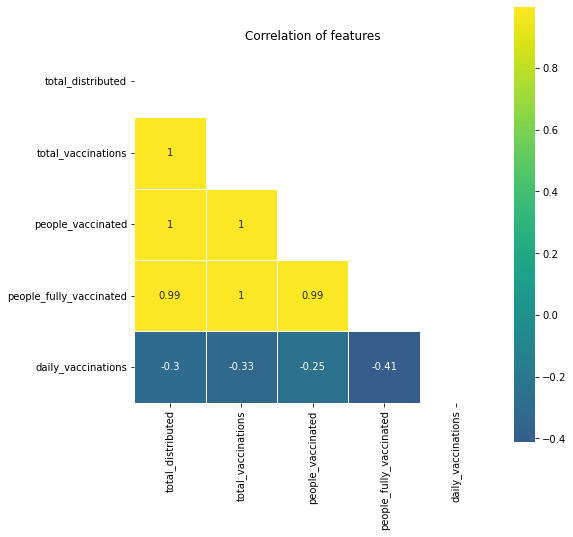

In [22]:
# visualize correlation of the features
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(df[features].corr(), dtype=bool))
plt.title("Correlation of features")
sns.heatmap(df[features].corr(), mask=mask, annot=True, cmap="viridis", center=0,
            square=True, linewidths=.5);

All features of interest other than "daily_vaccinations" are strongly correlated with each other. In time series, this may not hold any signifiance, as features with low correlation could be highly influential in the target of interest (assuming the time series isn't a random walk).

Because "people vaccinated" and "people_fully_vaccinated" are affected by whether an individual is getting a single-dose or a double-dose vaccine, those features may be harder to model and predict since I don't have data regarding the proportion of single-dose and double-dose vaccines administered.

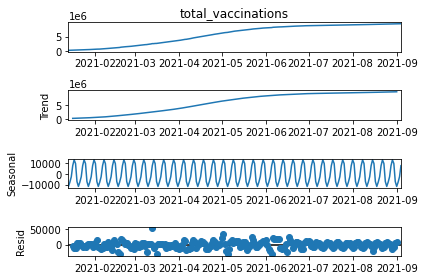

In [23]:
# decompose total vaccinations into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['total_vaccinations'])

# plot the decomposed time series
decomp.plot();

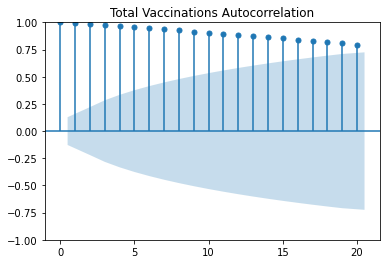

In [24]:
# plot autocorrelation function for total_vaccinations
plot_acf(df['total_vaccinations'], lags=20)
plt.title("Total Vaccinations Autocorrelation")
plt.show();

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


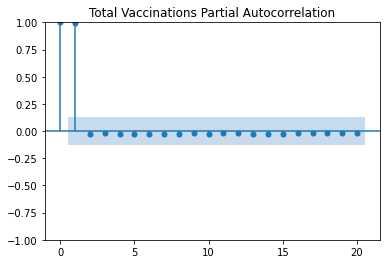

In [25]:
# plot partial autocorrelation function for total_vaccinations
plot_pacf(df['total_vaccinations'], lags=20);
plt.title("Total Vaccinations Partial Autocorrelation")
plt.show();

Autocorrelation plot confirms the positive trend for "total_vaccinations", and the partial autocorrelation plot shows that time T-1 is a significant predictor of time T.

In [26]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# Run ADF test on original (non-differenced!) data using the 
# constant and trend regression pattern for total vaccinations
interpret_dftest(adfuller(df['total_vaccinations'], regression = 'ct'))

Test Statistic                  -4.535360
p-value                          0.001321
#Lags Used                      14.000000
Number of Observations Used    220.000000
Critical Value (1%)             -4.000520
Critical Value (5%)             -3.430637
Critical Value (10%)            -3.138886
dtype: float64

Adjusted dickey-fuller test suggest that total vaccinations is stationary at an alpha level of 0.05 on original non-differenced data

In [27]:
# Run ADF test on differenced data using the regular regression pattern for total vaccinations
interpret_dftest(adfuller(df['total_vaccinations'].diff().dropna()))

Test Statistic                  -0.780808
p-value                          0.824695
#Lags Used                      15.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64

In [28]:
# Run ADF test on twice differenced data using the regular regression pattern for total vaccinations
interpret_dftest(adfuller(df['total_vaccinations'].diff().diff().dropna()))

Test Statistic                  -3.167787
p-value                          0.021927
#Lags Used                      15.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64

Adjusted dickey-fuller test suggests that "total_vaccinations" is stationary at an alpha level of 0.05 on undifferenced data.

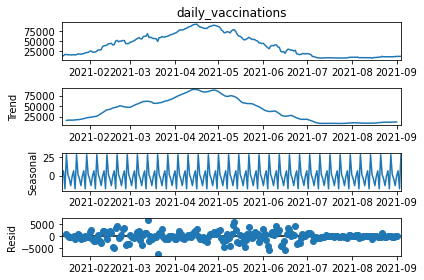

In [29]:
# decompose daily vaccinations into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['daily_vaccinations'])

# Plot the decomposed time series.
decomp.plot();

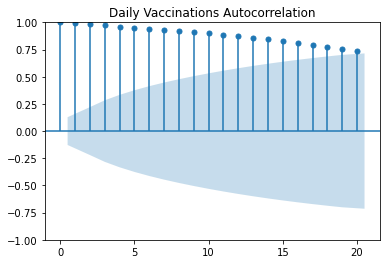

In [30]:
# plot autocorrelation function for daily_vaccinations
plot_acf(df['daily_vaccinations'], lags=20)
plt.title("Daily Vaccinations Autocorrelation")
plt.show();

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


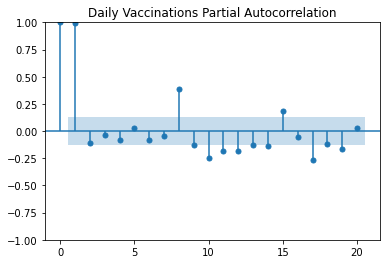

In [31]:
# plot partial autocorrelation function for daily_vaccinations
plot_pacf(df['daily_vaccinations'], lags=20);
plt.title("Daily Vaccinations Partial Autocorrelation")
plt.show();

Autocorrelation plot shows a positive trend for "daily_vaccinations", and partial autocorrelation plot may suggest some sort of seasonality, although this is most likely just a reflection of the variance in daily vaccinations.

In [32]:
# Run ADF test on original (non-differenced!) data using the 
# constant and trend regression pattern for daily vaccinations
interpret_dftest(adfuller(df['daily_vaccinations'], regression="ct"))

Test Statistic                  -2.412065
p-value                          0.373224
#Lags Used                      14.000000
Number of Observations Used    220.000000
Critical Value (1%)             -4.000520
Critical Value (5%)             -3.430637
Critical Value (10%)            -3.138886
dtype: float64

In [33]:
# Run ADF test on original (non-differenced!) data using the regular regression pattern for total vaccinations
interpret_dftest(adfuller(df['daily_vaccinations'].diff().dropna()))

Test Statistic                  -1.877032
p-value                          0.342942
#Lags Used                      15.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64

In [34]:
# Run ADF test on differenced data
interpret_dftest(adfuller(df['daily_vaccinations'].diff().diff().dropna()))

Test Statistic                -7.981790e+00
p-value                        2.611553e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64

Adjusted dickey-fuller test suggest that daily vaccinations is stationary at an alpha level of 0.05 on  twice-differenced data.